In [1]:
import tensorflow as tf

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Running on TPU:", tpu.master())
except ValueError:
    tpu = None
    print("Not connected to a TPU runtime")

if tpu:

    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy()

print("Number of replicas:", strategy.num_replicas_in_sync)


Running on TPU: 
Number of replicas: 8


In [2]:
from IPython import get_ipython
from IPython.display import display

In [3]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


In [4]:
# prompt: 구글마운트

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [8]:
data = pd.read_csv('/content/drive/MyDrive/datasets/news_summary_more.csv', nrows=100000)
print('전체 샘플수 :', len(data))

전체 샘플수 : 98401


In [9]:
data.head()

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...


In [10]:
# Print 15 random samples
data.sample(15)

,headlines,text
51668,Will not forgive or forget Smriti Irani: Rohit...,Speaking on Dalit student Rohith Vemula's deat...
46311,Actress Sridevi passes away after cardiac arrest,Veteran Bollywood actress Sridevi passed away ...
4317,Female ISIS member who let 5-yr-old die of thi...,A German female member of Islamic State is fac...
94079,Researchers successfully guess password by way...,Researchers at Newcastle University have demon...
93646,Sad some people think calling someone woman is...,Filmmaker-choreographer Farah Khan has tweeted...
78621,Trump's tweets reveal his creative personality...,Tweets by US President Donald Trump show that ...
64847,Google to reimburse customers who overpaid for...,Google has said that it will reimburse the cus...
57883,Google brings 'Two-wheeler' mode to Maps in India,Google has launched the 'Two-wheeler' mode on ...
31993,KXIP fall short despite Rahul's highest IPL sc...,RR defeated KXIP by 15 runs on Tuesday despite...
35819,Meetings with Kim Jong-un will be terrific: US...,US President Donald Trump on Thursday said tha...


# 데이터 전처리

# (1) 데이터 정리하기  
중복 샘플과 NULL 값이 존재하는 샘플 제거

In [11]:
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())

Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360


In [12]:
# text 기준으로 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98360


In [13]:
# 남은 null 값 확인
print(data.isnull().sum())



headlines    0
text         0
dtype: int64


In [14]:
# 남은 null 값 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))


전체 샘플수 : 98360


##### Text Normalization
텍스트 정규화를 위한 사전(dictionary)


In [15]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


##### 불용어 제거

In [16]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 전처리 함수

In [17]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "html.parser").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

print('=3')

=3


1. **소문자화**: 모든 문자를 소문자로 변환.
2. **HTML 태그 제거**: BeautifulSoup으로 제거.
3. **괄호 내용 제거**: 괄호로 닫힌 문자열 제거.
4. **쌍따옴표 제거**: 쌍따옴표 제거.
5. **약어 정규화**: 약어를 풀어쓰기.
6. **소유격 제거**: 소유격 제거.
7. **비영어 문자 제거**: 영어 외 문자를 공백으로 변환.
8. **문자 반복 줄이기**: 'm' 반복을 2개로 줄임.
9. **불용어 제거**: NLTK 불용어 리스트 사용.

### 전처리 결과 테스트






In [18]:
temp_headlines = 'Man arrested for cheating Amazon of â¹30 lakh by taking refunds'
temp_text = "The Indian Space Research Organisation on Wednesday unveiled Human Space Flight Centre in Bengaluru for its â¹10,000-crore manned space mission 'Gaganyaan' scheduled for 2021. ISRO said the centre will be responsible for development of engineering systems for crew survival in space and crew selection and training. It'll also pursue activities for sustained human space flight missions, ISRO added."

print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.
print("text: ", preprocess_sentence(temp_text))

headlines: man arrested for cheating amazon of lakh by taking refunds
text:  indian space research organisation wednesday unveiled human space flight centre bengaluru crore manned space mission gaganyaan scheduled isro said centre responsible development engineering systems crew survival space crew selection training also pursue activities sustained human space flight missions isro added


### 전체 Text 컬럼 전처리

In [19]:
# 전체 Text 데이터에 대한 전처리
clean_text = []

# 각 Text 데이터에 대해 전처리 함수 적용
for text in data['text']:
    clean_text.append(preprocess_sentence(text))


In [20]:
# 전체 Headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다.
clean_headlines = []

for headlines in data['headlines']:
    clean_headlines.append(preprocess_sentence(headlines, remove_stopwords=False))



<ipython-input-17-f7bf49beb6b2>:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  sentence = BeautifulSoup(sentence, "html.parser").text # <br />, <a href = ...> 등의 html 태그 제거


In [21]:
# 전처리 결과 확인
data.sample(5)

,headlines,text
46196,People like Owaisi have jinn of Jinnah: Union ...,Union Minister Giriraj Singh on Sunday said pe...
82418,Aussie cricketers mock their unemployment on s...,Australian cricketers including David Warner m...
31793,Woman's 'runny nose' found to be brain fluid leak,"A US-based woman diagnosed to have a ""runny no..."
56329,Customs duty on mobile phones hiked to 15% fro...,The government on Thursday raised the customs ...
52057,Twitter users turn Hardik Pandya's run-out int...,After Hardik Pandya got run-out in the second ...


In [22]:
# 전처리 후 null값 확인
data.isnull().sum()

,0
headlines,0
text,0


In [23]:
# null 값 제거
data.dropna(axis=0, inplace=True)

In [24]:
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


#### 전처리 전후 text 유사도 분석_TF-IDF 백터화 + 코사인유사도 계산

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

original_texts = data['text'].sample(1000, random_state=42)  # 원본 텍스트
processed_texts = pd.Series(clean_text).sample(1000, random_state=42)
 # 전처리 적용

# TF-IDF 벡터화
vectorizer = TfidfVectorizer()
original_tfidf = vectorizer.fit_transform(original_texts)
processed_tfidf = vectorizer.fit_transform(processed_texts)

# 코사인 유사도 계산
original_similarity = cosine_similarity(original_tfidf)
processed_similarity = cosine_similarity(processed_tfidf)

# 유사도 평균 비교
original_similarity_mean = np.mean(original_similarity)
processed_similarity_mean = np.mean(processed_similarity)

original_similarity_mean, processed_similarity_mean

(0.03427105420703843, 0.010260630907198347)

첫 번째 값(≈0.0343): 원본 텍스트(전처리 전)에 대한 유사도 평균  
두 번째 값(≈0.0103): 전처리된 텍스트(전처리 후)에 대한 유사도 평균  
##### 평균 유사도 자체는 줄어들어 전처리를 통해 노이즈가 정리되고 불용어 등의 제거효과를 보았다고 해석할 수 있다.

전처리 결과 데이터 프레임 저장

In [29]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


# (2) 데이터 분리

샘플의 최대 길이 정하기  

  
Headlines과 Text 의 최소, 최대, 평균

Headlines의 최소 길이 : 1
Headlines의 최대 길이 : 16
Headlines의 평균 길이 : 9.301108174054495
Text의 최소 길이 : 1
Text의 최대 길이 : 60
Text의 평균 길이 : 35.09968483123221


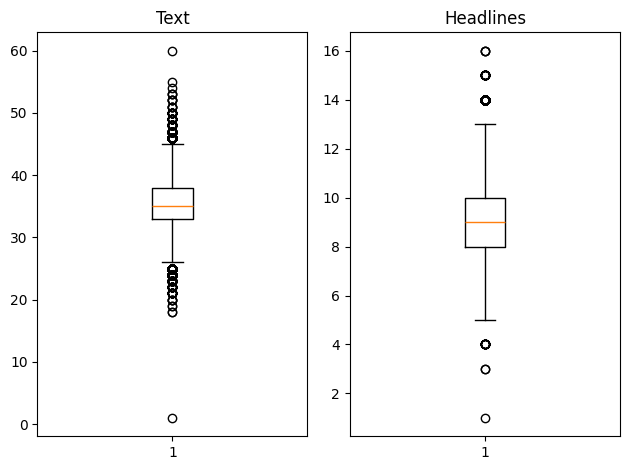

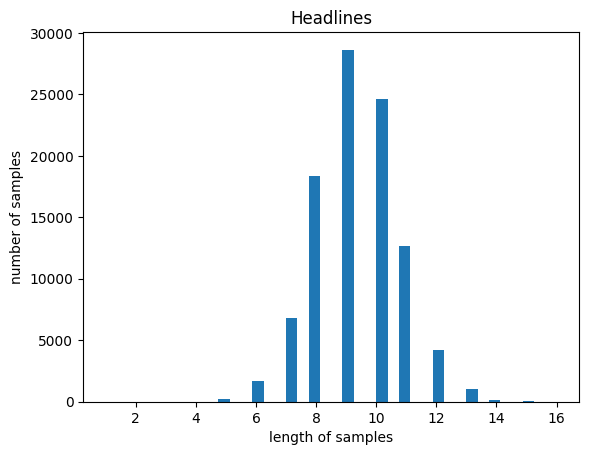

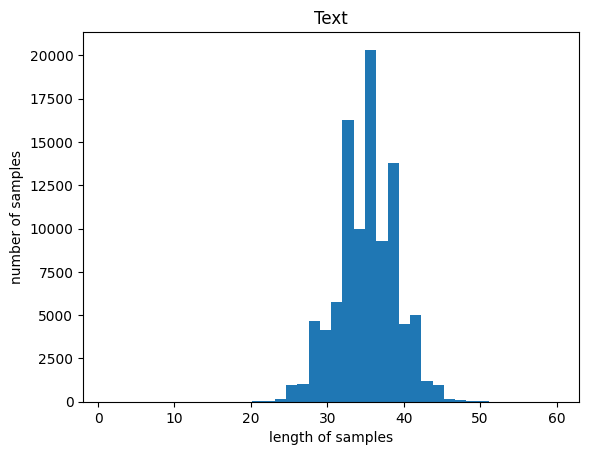

In [30]:
# 길이 분포 출력
import matplotlib.pyplot as plt

headlines_len = [len(s.split()) for s in data['headlines']]
text_len = [len(s.split()) for s in data['text']]

print('Headlines의 최소 길이 : {}'.format(np.min(headlines_len)))
print('Headlines의 최대 길이 : {}'.format(np.max(headlines_len)))
print('Headlines의 평균 길이 : {}'.format(np.mean(headlines_len)))
print('Text의 최소 길이 : {}'.format(np.min(text_len)))
print('Text의 최대 길이 : {}'.format(np.max(text_len)))
print('Text의 평균 길이 : {}'.format(np.mean(text_len)))

plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()


##### 최대 길이 정하기
headlines_max_len = 12
text_max_len = 40

In [31]:
headlines_max_len = 12
text_max_len = 40
print('=3')

=3


In [32]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
print('=3')

=3


In [33]:
below_threshold_len(headlines_max_len,  data['headlines'])
below_threshold_len(text_max_len, data['text'])

전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880235868239121
전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238714924766165


임의로 정의한 text_max_len과 summary_max_len의 길이보다 큰 샘플을 제외

In [34]:
# Text와 Headlines 길이 조건으로 필터링
data = data[
    (data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len))&
    (data['text'].apply(lambda x: len(x.split()) <= text_max_len))
]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89774



### 시작 토큰과 종료 토큰 추가하기


In [35]:
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


##### 인코더의 입력, 디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장






In [36]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스 생성

In [37]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)

encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

=3


테스트 데이터 분리

In [38]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17954


전체 데이터 분리






In [39]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71820
훈련 레이블의 개수 : 71820
테스트 데이터의 개수 : 17954
테스트 레이블의 개수 : 17954


# (3) 정수 인코딩


### Vocabulary
encoder_input_train 단어 집합

In [40]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


In [41]:
threshold = 10
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 65448
등장 빈도가 9번 이하인 희귀 단어의 수: 48069
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17379
단어 집합에서 희귀 단어의 비율: 73.44609460946094
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.789432687882129


In [42]:
src_vocab = 15000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 15,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


In [43]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[492, 1087, 206, 818, 323, 2979, 492, 206, 56, 4395, 2980, 1378, 206, 7360, 522, 1094, 4645, 4809, 308, 1328, 8405, 1039, 492, 1329, 4203, 1696, 4645, 382], [42, 3, 12, 1008, 4887, 324, 10, 228, 76, 94, 841, 11, 320, 7253, 17, 10, 42, 185, 76, 56, 4720, 387, 750, 10511, 191, 892, 129, 189, 1173, 892, 4887, 283, 105, 90, 1157, 4721], [335, 55, 1563, 2564, 25, 1095, 244, 2305, 674, 439, 6764, 12112, 365, 16, 1754, 1203, 3679, 1891, 486, 1, 25, 1095, 244, 1589, 1203, 34, 1, 1095, 87, 224, 820, 1134, 20, 7604, 5, 807, 1095, 5254]]


In [44]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)
print('=3')

=3


In [45]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28792
등장 빈도가 6번 이하인 희귀 단어의 수: 19757
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9035
단어 집합에서 희귀 단어의 비율: 68.61975548763546
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.657663677440647


In [46]:
tar_vocab = 8000
tar_tokenizer = Tokenizer(num_words=tar_vocab)
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train)
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 22, 5070, 2762, 265, 295, 1093, 3, 3759, 348], [1, 60, 4393, 1588, 701, 5, 4698, 4, 14], [1, 151, 2147, 532, 39, 457, 956], [1, 867, 1231, 95, 13, 1054, 546], [1, 1197, 3, 1998, 2825, 5, 357, 1854, 2898]]
target
decoder  [[22, 5070, 2762, 265, 295, 1093, 3, 3759, 348, 2], [60, 4393, 1588, 701, 5, 4698, 4, 14, 2], [151, 2147, 532, 39, 457, 956, 2], [867, 1231, 95, 13, 1054, 546, 2], [1197, 3, 1998, 2825, 5, 357, 1854, 2898, 2]]


In [47]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71819
훈련 레이블의 개수 : 71819
테스트 데이터의 개수 : 17954
테스트 레이블의 개수 : 17954



## 패딩하기


In [48]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


# (4) 모델 설계하기

### 인코더 설계

In [49]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)  # LSTM 2 layers, getting output, hidden state, and cell state
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)  # Passing the output of LSTM 1 to LSTM 2

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)  # LSTM 3 layers, getting output, hidden state, and cell state
encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)  # Passing the output of LSTM 2 to LSTM 3

### 디코더 설계

##### 디코더 입력층 설계

In [50]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일  
하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 함



##### 디코더 출력층 설계

In [51]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 128)        │      1,920,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 40, 256),      │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │      1,024,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, None, 8000)     │      2,056,000 │ lstm_3[0][0]           │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 6,839,104 (26.09 MB)

 Trainable params: 6,839,104 (26.09 MB)

 Non-trainable params: 0 (0.00 B)

### 디코더 출력증 업데이트 with 어텐션 메커니즘  

In [52]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 40)             │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 40, 128)        │      1,920,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm (LSTM)               │ [(None, 40, 256),      │        394,240 │ embedding[0][0]        │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_1 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm[0][0]             │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, None, 128)      │      1,024,000 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_2 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm_1[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_3 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_1[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_2[0][1],          │
│                           │ 256)]                  │                │ lstm_2[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_3[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_2[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_3[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, None, 8000)     │      4,104,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,887,360 (33.90 MB)

 Trainable params: 8,887,360 (33.90 MB)

 Non-trainable params: 0 (0.00 B)

# (5) 모델 훈련하기


In [53]:
with strategy.scope():
    # 인코더 설계 시작
    embedding_dim = 128
    hidden_size = 256

    # 인코더
    encoder_inputs = Input(shape=(text_max_len,))
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
    encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

    # 디코더 설계
    decoder_inputs = Input(shape=(None,))
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # 어텐션 층
    attn_layer = AdditiveAttention(name='attention_layer')
    attn_out = attn_layer([decoder_outputs, encoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

    # 모델 정의
    model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
    model.summary()

    # 모델 컴파일
    model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 40)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_2 (Embedding)   │ (None, 40, 128)        │      1,920,000 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_4 (LSTM)             │ [(None, 40, 256),      │        394,240 │ embedding_2[0][0]      │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, None)           │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_5 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm_4[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_3 (Embedding)   │ (None, None, 128)      │      1,024,000 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_6 (LSTM)             │ [(None, 40, 256),      │        525,312 │ lstm_5[0][0]           │
│                           │ (None, 256), (None,    │                │                        │
│                           │ 256)]                  │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ lstm_7 (LSTM)             │ [(None, None, 256),    │        394,240 │ embedding_3[0][0],     │
│                           │ (None, 256), (None,    │                │ lstm_6[0][1],          │
│                           │ 256)]                  │                │ lstm_6[0][2]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ attention_layer           │ (None, None, 256)      │            256 │ lstm_7[0][0],          │
│ (AdditiveAttention)       │                        │                │ lstm_6[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concat_layer              │ (None, None, 512)      │              0 │ lstm_7[0][0],          │
│ (Concatenate)             │                        │                │ attention_layer[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, None, 8000)     │      4,104,000 │ concat_layer[0][0]     │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 8,887,360 (33.90 MB)

 Trainable params: 8,887,360 (33.90 MB)

 Non-trainable params: 0 (0.00 B)

In [54]:
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=256,
    callbacks=[es],
    epochs=50
)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 40s 89ms/step - loss: 5.9944 - val_loss: 5.2673
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 5.2034 - val_loss: 4.9509
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - loss: 4.8948 - val_loss: 4.6994
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 4.6662 - val_loss: 4.5331
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - loss: 4.4498 - val_loss: 4.4187
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 4.3116 - val_loss: 4.2841
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 4.1906 - val_loss: 4.2008
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 4.0520 - val_loss: 4.1084
Epoch 9/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 3.9432 - val_loss: 4.0459
Epoch 10/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 3.8322 - val_loss: 3.9862
Epoch 11/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 3.7444 - val_loss: 3.9271
Epoch 12/50
281/281 ━━━━━━━━━━

### 학습 결과 시각화






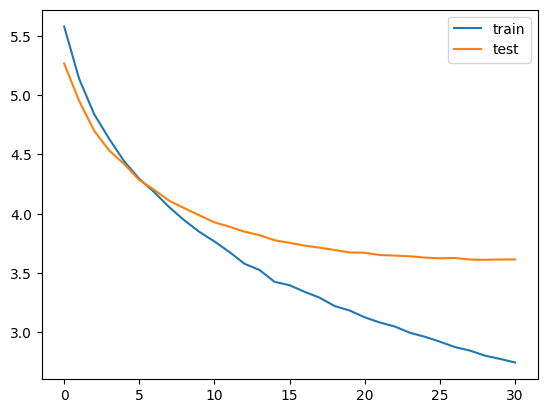

In [55]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# 성능개선 HP tuning 실험
- optimizer : rmsprop -> Adam(NLP에서 더 잘 동작한다고 함)
- LR : adam과의 시너지를 위해 learning_rate=1e-3
- ReduceLROnPlateau 콜백으로 동적으로 lr 조정
- ES patience는 5로 늘리고 ReduceLROnPlateau patience를 2로 타이트하게 반응하도록
- batch size : 256 -> 128

In [56]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

with strategy.scope():
    # 인코더 설계 시작
    embedding_dim = 128
    hidden_size = 256

    # 인코더
    encoder_inputs = Input(shape=(text_max_len,))
    enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

    # 인코더의 LSTM 1
    encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

    # 인코더의 LSTM 2
    encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

    # 인코더의 LSTM 3
    encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
    encoder_outputs, state_h, state_c = encoder_lstm3(encoder_output2)

    # 디코더 설계
    decoder_inputs = Input(shape=(None,))
    dec_emb_layer = Embedding(tar_vocab, embedding_dim)
    dec_emb = dec_emb_layer(decoder_inputs)

    # 디코더의 LSTM
    decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
    decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

    # 어텐션 층
    attn_layer = AdditiveAttention(name='attention_layer')
    attn_out = attn_layer([decoder_outputs, encoder_outputs])

    # 어텐션의 결과와 디코더의 hidden state들을 연결
    decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

    # 디코더의 출력층
    decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
    decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

    # 모델 정의
    model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

    # 모델 컴파일
    model.compile(optimizer=Adam(learning_rate=1e-3),
                  loss='sparse_categorical_crossentropy')

In [57]:
es = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

history = model.fit(
    x=[encoder_input_train, decoder_input_train],
    y=decoder_target_train,
    validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
    batch_size=128,
    callbacks=[es, reduce_lr],
    epochs=50
)

Epoch 1/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 50s 59ms/step - loss: 5.8468 - val_loss: 5.0975 - learning_rate: 0.0010
Epoch 2/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 32ms/step - loss: 4.9699 - val_loss: 4.5219 - learning_rate: 0.0010
Epoch 3/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 4.4239 - val_loss: 4.1529 - learning_rate: 0.0010
Epoch 4/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 4.0121 - val_loss: 3.9311 - learning_rate: 0.0010
Epoch 5/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - loss: 3.7272 - val_loss: 3.7831 - learning_rate: 0.0010
Epoch 6/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 3.5356 - val_loss: 3.6860 - learning_rate: 0.0010
Epoch 7/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 33ms/step - loss: 3.3568 - val_loss: 3.6186 - learning_rate: 0.0010
Epoch 8/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 19s 34ms/step - loss: 3.1855 - val_loss: 3.5599 - learning_rate: 0.0010
Epoch 9/50
562/562 ━━━━━━━━━━━━━━━━━━━━ 21s 36ms/step - loss: 3.0280 - val_loss: 3.5248 - learning_rate:

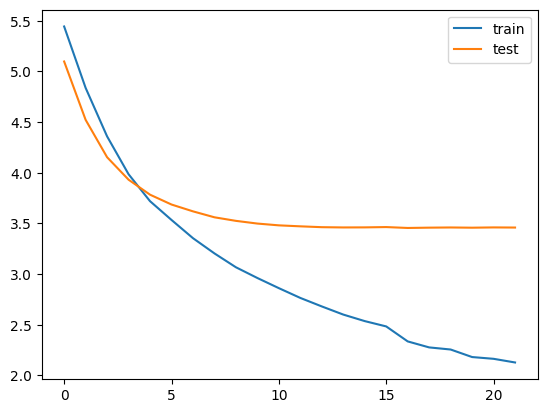

In [58]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

# (6) 인퍼런스 모델 구현하기


테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [59]:
src_index_to_word = src_tokenizer.index_word # text 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # headlines 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # headlines 단어 집합에서 정수 -> 단어를 얻음

print('=3')

=3


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [60]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층

In [61]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수

In [62]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


정답 문장이 없는 추론(inference) 단계에서 모델 설계를 별도로 해주는 이유:  
생성해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문





# (7) 인퍼런스 모델 테스트


In [63]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# headlines의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp = ''
    for i in input_seq:
        if ((i != 0) and (i != tar_word_to_index['sostoken']) and (i != tar_word_to_index['eostoken'])):
            temp = temp + tar_index_to_word[i] + ' '
    return temp.strip()

print('=3')

=3


실제요약과 예측 요약 비교















In [ ]:
# for i in range(50, 100):
#     print("원문 :", seq2text(encoder_input_test[i]))
#     print("실제 요약 :", seq2headlines(decoder_input_test[i]))
#     print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
#     print("\n")

In [65]:
with strategy.scope():
    # text 단어 집합에서 정수 -> 단어
    src_index_to_word = src_tokenizer.index_word
    # headlines 단어 집합에서 단어 -> 정수
    tar_word_to_index = tar_tokenizer.word_index
    # headlines 단어 집합에서 정수 -> 단어
    tar_index_to_word = tar_tokenizer.index_word

    # ==================
    # 인코더 설계 (Inference용)
    # ==================
    encoder_model = Model(inputs=encoder_inputs,
                          outputs=[encoder_outputs, state_h, state_c])

    # 이전 시점의 상태들을 저장하는 텐서
    decoder_state_input_h = Input(shape=(hidden_size,))
    decoder_state_input_c = Input(shape=(hidden_size,))

    dec_emb2 = dec_emb_layer(decoder_inputs)

    # 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태를 버리지 않고 추론에서 활용
    decoder_outputs2, state_h2, state_c2 = decoder_lstm(
        dec_emb2,
        initial_state=[decoder_state_input_h, decoder_state_input_c]
    )


    # ==================
    # 어텐션 함수 (Inference용)
    # ==================
    decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
    attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
    decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

    # 디코더의 출력층
    decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat)

    # 최종 디코더 모델 (Inference 전용)
    decoder_model = Model(
        [decoder_inputs, decoder_hidden_state_input,
         decoder_state_input_h, decoder_state_input_c],
        [decoder_outputs2, state_h2, state_c2]
    )


    # ==================
    # 인퍼런스용 디코딩 함수
    # ==================
    def decode_sequence(input_seq):
        # 1) 인코더로부터 출력과 상태를 얻음
        e_out, e_h, e_c = encoder_model.predict(input_seq)

        # 2) <SOS> 토큰 시퀀스 생성
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = tar_word_to_index['sostoken']  # 'sostoken'이 실제로 존재해야 함

        stop_condition = False
        decoded_sentence = ''

        while not stop_condition:
            # 3) 디코더 예측 (이전 상태 + 인코더 출력 사용)
            output_tokens, h, c = decoder_model.predict([target_seq, e_out, e_h, e_c])

            # 4) 가장 높은 확률의 단어 토큰
            sampled_token_index = np.argmax(output_tokens[0, -1, :])
            sampled_token = tar_index_to_word[sampled_token_index]

            # 5) eostoken 확인
            if (sampled_token != 'eostoken'):
                decoded_sentence += ' ' + sampled_token

            if (sampled_token == 'eostoken'
                or len(decoded_sentence.split()) >= (headlines_max_len - 1)):
                stop_condition = True

            # 6) 다음 타임스텝을 위한 target_seq 업데이트
            target_seq = np.zeros((1,1))
            target_seq[0, 0] = sampled_token_index

            # 7) 디코더 상태 업데이트
            e_h, e_c = h, c

        return decoded_sentence.strip()

    # ==================
    # seq2text / seq2headlines 유틸 함수
    # ==================
    def seq2text(input_seq):
        temp=''
        for i in input_seq:
            if (i!=0):
                temp = temp + src_index_to_word[i] + ' '
        return temp

    def seq2headlines(input_seq):
        temp = ''
        for i in input_seq:
            if ((i != 0) and
                (i != tar_word_to_index['sostoken']) and
                (i != tar_word_to_index['eostoken'])):
                temp = temp + tar_index_to_word[i] + ' '
        return temp.strip()

    # ==================
    # 실제 예측 (샘플)
    # ==================
    for i in range(50, 60):
        print("원문 :", seq2text(encoder_input_test[i]))
        print("실제 요약 :", seq2headlines(decoder_input_test[i]))
        print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
        print("\n")

원문 : talking cape town test ball tampering scandal former australia batsman dean jones said feels like huge tattoo cannot erase three boys old enough make right decisions pay consequences added 
실제 요약 : tattoo on our we cannot on ball tampering row
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 507ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 476ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 486ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 455ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
예측 요약 : would have been like to sleep with him aussie player


원문 : luxury hotel uae employed eight cats help employees beat work related stress media report said abu dhabi based hotels resorts said recruited part office cat policy assist employees increasing productivity guests visiting hot

# (8) 추출적 요약


In [9]:
! pip install summa


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54387 sha256=a548d9dc2ffe95df32eee97d221f3c30e9d5a6b85872681e4c70b3cee9877d45
  Stored in directory: /root/.cache/pip/wheels/10/2d/7a/abce87c4ea233f8dcca0d99b740ac0257eced1f99a124a0e1f
Successfully built summa


In [10]:
from summa.summarizer import summarize

In [4]:
# prompt: 구글마운트

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
import pandas as pd
data = pd.read_csv('/content/drive/MyDrive/news_summary_more.csv', nrows=100000)

In [6]:
sample_text = ' '.join(data['text'].sample(5).astype(str).tolist())

In [14]:
print('Summary:')
print(summarize(sample_text, ratio=0.5, split=True))

Summary:
['Slamming Rajya Sabha MPs for continuously disrupting the Parliament, Vice President Venkaiah Naidu on Wednesday said, "You are testing the patience of the people of the country." Adding that no bills have been transacted and that the country wants development, the Vice President said, "Please understand that the entire country is agitated with what is happening in the House." Swara Bhasker, while praising women who are speaking up on #MeToo movement, said, "Kudos goes to all the women who are braving their past trauma and reliving it and claiming their own stories with their own names." "I think the #MeToo movement was a long time pending in India and it\'s good that it has finally come out," Swara added.', 'His death appeared to be a "heartbreaking accident" as Snooty died after getting stuck in a maintenance hatch, South Florida Museum CEO Brynne Anne Besio said.', 'Eight policemen, including the Station House Officer of Dhanaura police station in UP\'s Amroha, were suspen

In [15]:
print('Summary:')
print(summarize(sample_text, words=50))

Summary:
Eight policemen, including the Station House Officer of Dhanaura police station in UP's Amroha, were suspended for "dereliction of duty" after a Dalit man allegedly died in custody.
The Jammu and Kashmir Police has banned the use of smartphones by on-duty personnel, blaming this for an increase in weapons-snatching.


In [19]:
for idx in range(5):
    sample_text = data.loc[idx, 'text']
    summary_result = summarize(sample_text, words=20)

    print(f"원본 텍스트:")
    print(sample_text[:200], "...")
    print("----- 요약 결과 -----")
    print(summary_result if summary_result else "요약문이 없거나 텍스트가 너무 짧습니다.")
    print("\n")

원본 텍스트:
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and  ...
----- 요약 결과 -----
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.


원본 텍스트:
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins.  ...
----- 요약 결과 -----
Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


원본 텍스트:
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sha

# 회고


- 배운 점:  
이번 프로젝트를 하면서 전처리하는 과정의 중요성을 이미지 데이터보다 크게 느끼는 부분이 많았다. 텍스트 정규화, 불용어 제거, 중복된 기사 제거, 시작/종료 토큰 추가 같은 작업을 코드로 구현하면서 자연어에서 데이터 품질이 모델 성능에 미치는 영향을 확인할 수 있었다. 개인적으로 실험해보고 접근해 본 점은 전처리 과정의 속도를 양상시키는 코드 구성 측면에서 4가지 방법론을 배웠고 멀티프로세싱을 시도해보았다. 그리고 전처리 전후과정에서 달라지는 샘플 유사도 분석method를 실험해보았다. (TF-IDF 백터화, 코사인유사도 계산 등).
트랜스포머 아키텍쳐 이전의 모델들의 변천사를 케창딥 때보다 좀더 실무적으로 리뷰할 수 있었던 것에 만족한다. 아직 추상적 요약을 네이버 등 사용하고 있는 것으로 보아 추상과 추출에 대한 비교 이해는 아직은 중요해 보이고 추출에 대한 성능실험을 서비스프로젝트로 이어갈 수 있다면 유의미한 활동이지 않을까 싶다.

- 아쉬운 점 :   
하이퍼파라미터 튜닝과 다양한 실험을 충분히 하지 못한 것이 조금 아쉽다. 전처리 전후로 데이터 백업에 대한 워크플로우를 아직 메뉴얼링이 되있지 않아 토크나이징과 전처러 과정의 중복 시행 발생 등은 앞으로 개선이 필요해 보인다.
   
- 느낀 점 :  
실제 뉴스 데이터를 다루며 전처리부터 모델 설계, 학습, 예측까지 전체 파이프라인을 구축하는 과정은 도전적이었지만 그만큼 보람도 컸다. 코드 디버깅과 오류를 해결하면서 문제를 해결하는 능력이 확실히 늘어났고, 데이터의 특성과 모델 구조에 대해 깊이 고민하는 시간이 많았다. 추출적 요약과 추상적 요약을 비교하면서 자연어 처리의 다양한 가능성을 체감한 점도 의미 있는 경험이었다.  
   
- 어려웠던 점 :  
 데이터 전처리는 리소스와 운영과정에서의 애로사항이 있었고 인퍼런스 아키덱쳐까지 전반에 걸쳐 디버깅 과정 발생시 프로젝트가 리셋될 수 있는 상황이 다소 절망스러울 때가 있었다. 케창딥에서도 RNN과 transformer 학습과정이 다소 컴팩트했는데 exploration의 프로젝트를 그 학습기간에 연결해 이어가는 커리큘럼도 나름 괜찮을 것 같습니다.